----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [2]:
#You must install the surprise package in Google Colab in order to use the same
!pip install surprise

     |████████████████████████████████| 11.8 MB 33.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619411 sha256=c429cd84681b409a6b4a1fb89801f180483056fb938c4e026ab3f7f10388c06d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [10]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import defaultdict 

from sklearn.metrics import mean_squared_error

In [12]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/Neural/ratings_Electronics.csv', header=None) 
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] 
df = df.drop('timestamp', axis=1) 
df_copy = df.copy(deep=True)

**As this dataset is very large and has 78,24,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence we can reduce the dataset by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [13]:
users = df.user_id
ratings_count = dict()
for user in users:
    if user in ratings_count:
        ratings_count[user] += 1
    else:
        ratings_count[user] = 1    

In [14]:
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [15]:
users = df.prod_id
ratings_count = dict()
for user in users:
    if user in ratings_count:
        ratings_count[user] += 1
    else:
        ratings_count[user] = 1    

In [16]:
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = df.loc[~df.prod_id.isin(remove_users)]

In [17]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [18]:
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**Obervations:**
- After filtering the data we have:
- 65,290 entries present in the dataset
- 3 columns present namely (user_id, prod_id and rating)

In [19]:
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [20]:
df_final.count()

user_id    65290
prod_id    65290
rating     65290
dtype: int64

**Obervations:**
- No missing values

In [21]:
df_final['rating'].describe().T

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Obervations:**
- Average rating in this dataset is ~4.3.
- Quartile 2 and above have a rating of 5.

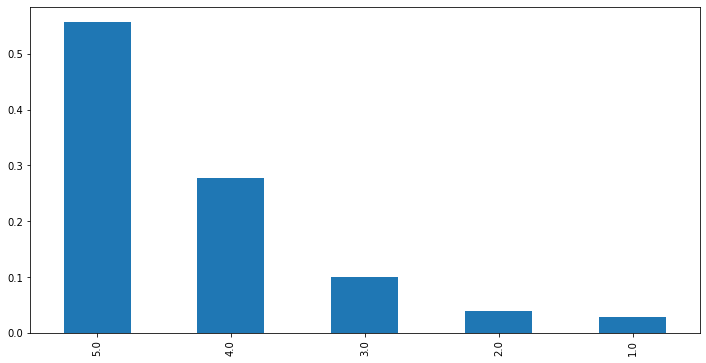

In [22]:
plt.figure(figsize = (12,6))
df_final['rating'].value_counts(1).plot(kind='bar')
plt.show()

**Observations:**
- Maximum ratings are of value 5.
- Very few ratings are of value 1 and 2 (less than 5%).

In [23]:
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset

In [24]:
# Top 10 users based on rating
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

In [25]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


**Observations:**
- There are 5689 products and 1540 unique users in the final data.

In [26]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [27]:
average_rating = df_final.groupby('prod_id').mean()['rating']

count_rating = df_final.groupby('prod_id').count()['rating']

final_rating = pd.DataFrame({'average_rating':average_rating, 'rating_count':count_rating})

final_rating = final_rating.sort_values(['average_rating'],ascending=False)

final_rating.head()

,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [28]:
def top_n_products(final_rating, n, min_interaction):
    
    recommendations = final_rating[final_rating['rating_count'] > min_interaction] 
    recommendations = recommendations.sort_values(by='average_rating', ascending=False)
    
    return recommendations.index[:n]

In [29]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [30]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using collaborative filtering

- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based
- Model based

#### Building a baseline user user similarity based recommendation system

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library
- Please use the following code to `install the surprise` library. You don't need to run the following code if the surprise library is installed on your system.

**!pip install surprise**

In [31]:
from surprise import accuracy

from surprise.reader import Reader

from surprise.dataset import Dataset

from surprise.model_selection import GridSearchCV

from surprise.model_selection import train_test_split

from surprise.prediction_algorithms.knns import KNNBasic

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise.model_selection import KFold

from surprise import CoClustering

In [32]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    user_est_true = defaultdict(list)
    
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall) 
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) 

In [33]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [34]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [35]:
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

sim_user_user.fit(trainset)

precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**
- The RMSE tells us how far the predicted ratings are from the actual ratings.
- 85.8% of the products are recommended out of all relevant products.
- Out of all the recommended movies 85.5% are relevant.
- The high F1-score (0.856) tells us that most of the recommended movies were relevant.

In [36]:
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [37]:
df_final[df_final.prod_id=="1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* It can be observed from the **above list that user "A34BZM6S9L7QI4" has not seen a product with productId "1400501466"**.

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466`** 

In [38]:
#predicting rating for a sample user with a non interacted product.
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [39]:
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9712749536767106
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above

In [40]:
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

sim_user_user_optimized.fit(trainset)
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is slightly better than the baseline model**. Along with this **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

In [44]:
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466",r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [45]:
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466",r_ui=5,verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
- Actual and predicted estimations are very close.
- After tuning the model the predictions of the rating are closer to the actual ratings.

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric

In [48]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the inner id of the above user.

[6, 7, 17, 26, 32]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

In [49]:
def get_recommendations(data, user_id, top_n, algo):
    
    recommendations = []
    
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    for item_id in non_interacted_products:
        
        est = algo.predict(user_id, item_id).est
        
        recommendations.append((item_id, est))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] 

#### Predicted top 5 products for userId="A3LDPF5FMB782Z" with similarity based recommendation system

In [50]:
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [51]:
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correcting the Ratings and Ranking the above products

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [52]:
def ranking_products(recommendations, final_rating):
  
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [53]:
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item Item Similarity-based collaborative filtering recommendation systems 

In [54]:
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

sim_item_item.fit(trainset)

precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~84%. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

In [55]:
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted yet i.e. `prod_id=1400501466`** 

In [56]:
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

In [57]:
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9747214498543801
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

In [58]:
sim_options = {'name': 'msd',
               'user_based': False}

sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3, random_state=1, verbose=False)

sim_item_item_optimized.fit(trainset)

precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9646
Precision:  0.841
Recall:  0.867
F_1 score:  0.854


**Observations:**
- F1 score obtained after tuning the model is better than the baseline model.
- RMSE of this model is lesser than that of the baseline model which indicates that the models performance has improved after tuning the hyperparameters.


In [59]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating** for the same **`userId=A34BZM6S9L7QI4`** but for a product which this user **has not interacted before** i.e. `prod_id==1400501466`, by using the optimized model as shown below - 

In [60]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar users to the user with internal id 0 based on the `msd` distance metric

In [61]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

#### Predicted top 5 products for userId="A1A5KUIIIHFF4U" with similarity based recommendation system

In [62]:
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [63]:
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B0000X0VCY,5
1,B00029U1DK,5
2,B0019EHU8G,5
3,B001MSU1FS,5
4,B001SJVU6K,5


In [64]:
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0019EHU8G,90,5,4.894591
1,B00029U1DK,30,5,4.817426
2,B001MSU1FS,30,5,4.817426
3,B0000X0VCY,21,5,4.781782
4,B001SJVU6K,12,5,4.711325


### Model Based Collaborative Filtering - Matrix Factorization

#### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [65]:
svd = SVD(random_state=1)

svd.fit(trainset)

precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**
- The F1-score obtained using the SVD model on the test set is lower as compared to the previous tuned model (user-user based recommendation system)
- The precision rates of the SVD model is higher as compared to the user-user based recommendation model.

In [66]:
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted before i.e. `productId=1400501466`, as shown below - 

In [67]:
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In [68]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

gs_.fit(data)

print(gs_.best_score['rmse'])

print(gs_.best_params['rmse'])

0.8978184560696526
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

Now we will **the build final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation

In [69]:
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)

svd_optimized=svd_optimized.fit(trainset)

precision_recall_at_k(svd_optimized)

RMSE: 0.8814
Precision:  0.853
Recall:  0.874
F_1 score:  0.863


**Observations:**
- The model's performance after tuning the hyperparameters has not changed significantly as compared to the baseline model.

In [70]:
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.238900563954771, details={'was_impossible': False})

In [71]:
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.20   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.204418940307481, details={'was_impossible': False})

**Observations:**
- We can observe that the predicted rating from the optimized model is closer to the actual rating as compared to the baseline model.

In [72]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [74]:
svd_recommendations = get_recommendations(df_final,'A2XIOXRRYX0KZY', 5, svd_optimized)

In [75]:
ranking_products(svd_recommendations,final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0033PRWSW,15,4.897396,4.639197
1,B0010Y414Q,11,4.922592,4.621080
2,B000JV9LUK,10,4.928989,4.612761
3,B00AR95ESC,9,4.918866,4.585533
4,B00065AO0K,5,4.912416,4.465202
